# Data Science Lab 5
#### Aimun Khan (aak2629) and Caleb Johnson (cj2273)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import pprint as pp
import random
from sklearn import linear_model

from sklearn.model_selection import train_test_split

# 1.0)

In [193]:
#Grab the data and look at each feature's statistics. Delete the 'Unnamed' id column

filename = 'cs-training.csv'
data = pd.read_csv(filename)
data.drop(['Unnamed: 0'], inplace=True, axis=1)

In [194]:
#We see that about 6.7% of the samples have a True label in the feature, SeriousDlquin2yrs.

data.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


In [195]:
#Rename the label to something easier to work with
data['label'] = data.SeriousDlqin2yrs
data.drop(['SeriousDlqin2yrs'], inplace=True, axis=1)

In [196]:
#Check for nulls and NaNs
data.isnull().sum()

RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
label                                       0
dtype: int64

In [197]:
#Assume NaNs in MonthlyIncome suggest no income, and change all NaNs to 0.
data.MonthlyIncome.fillna(0, inplace=True)

#Fill in NaNs in NumberOfDependents with feature mean
data.NumberOfDependents.fillna(data.NumberOfDependents.mean(), inplace=True)

In [205]:
features = data.drop(['label'], axis=1)
labels = data.label

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

In [78]:
#Find an optimal tree depth for an xgb model

accuracies = []
aucs = []
val_acc = []
val_auc = []

num_splits = 5
depths = [2,3,4,5,6,7,8]

for i in range(len(depths)):
    print('Evaluating Tree Depth: {}'.format(depths[i]))
    accuracy = []
    auc = []
    kf = KFold(n_splits=5)
    _ = kf.get_n_splits(X_train, y_train)
    
    for train_index, test_index in kf.split(X_train, y_train):
        Xtrain, Xtest = features.iloc[train_index], features.iloc[test_index]
        ytrain, ytest = labels.iloc[train_index], labels.iloc[test_index]
        
        params = {'max_depth':depths[i], 'eta':.05, 'gamma':1.5, 'silent':1, 'objective': 'binary:logistic',
                 'early_stopping_rounds':5, 'scale_pos_weight':ratio}
        num_round = 800
        
        dtrain = xgb.DMatrix(Xtrain, ytrain)
        dtest = xgb.DMatrix(Xtest, ytest)
        model = xgb.train(params, dtrain, num_round)
        pred = model.predict(dtest)
        fpr_temp, tpr_temp, thresholds = metrics.roc_curve(ytest, pred)
        auc_temp = metrics.auc(fpr_temp, tpr_temp)
        accuracy.append(metrics.accuracy_score(ytest, pred.round()))
        auc.append(np.array(auc_temp).mean())
        
    # Grab the mean CV score and validation score
    dtest = xgb.DMatrix(X_test, y_test)
    pred = model.predict(dtest)
    val_acc.append(metrics.accuracy_score(y_test, pred.round()))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
    val_auc.append(metrics.auc(fpr, tpr))
    accuracies.append(np.array(accuracy).mean())
    aucs.append(np.array(auc).mean())

Evaluating Tree Depth: 2
Evaluating Tree Depth: 3
Evaluating Tree Depth: 4
Evaluating Tree Depth: 5
Evaluating Tree Depth: 6
Evaluating Tree Depth: 7
Evaluating Tree Depth: 8


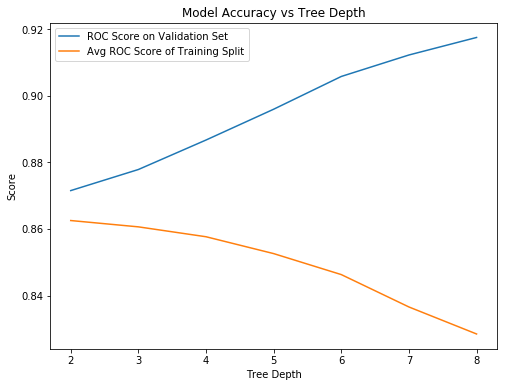

In [79]:
fig, ax = plt.subplots(figsize=(8,6))
_ = plt.plot(depths, val_auc, label='ROC Score on Validation Set')
_ = plt.plot(depths, aucs, label='Avg ROC Score of Training Split')
_ = plt.title('Model Accuracy vs Tree Depth')
_ = plt.xlabel('Tree Depth')
_ = plt.ylabel('Score')
_ = plt.legend()

### A depth of 8 is optimal from the depths we looked at. Let's look at deeper trees

In [47]:
accuracies = []
aucs = []
val_acc = []
val_auc = []

num_splits = 5
depths = [9, 10, 11, 12]

for i in range(len(depths)):
    print('Evaluating Tree Depth: {}'.format(depths[i]))
    accuracy = []
    auc = []
    kf = KFold(n_splits=5)
    _ = kf.get_n_splits(X_train, y_train)
    
    for train_index, test_index in kf.split(X_train, y_train):
        Xtrain, Xtest = features.iloc[train_index], features.iloc[test_index]
        ytrain, ytest = labels.iloc[train_index], labels.iloc[test_index]
        
        params = {'max_depth':depths[i], 'eta':.05, 'gamma':1.5, 'silent':1, 'objective': 'binary:logistic',
                 'early_stopping_rounds':5, 'scale_pos_weight':ratio}
        num_round = 800
        
        dtrain = xgb.DMatrix(Xtrain, ytrain)
        dtest = xgb.DMatrix(Xtest, ytest)
        model = xgb.train(params, dtrain, num_round)
        pred = model.predict(dtest)
        fpr_temp, tpr_temp, thresholds = metrics.roc_curve(ytest, pred)
        auc_temp = metrics.auc(fpr_temp, tpr_temp)
        accuracy.append(metrics.accuracy_score(ytest, pred.round()))
        auc.append(np.array(auc_temp).mean())
        
    # Grab the mean CV score and validation score
    dtest = xgb.DMatrix(X_test, y_test)
    pred = model.predict(dtest)
    val_acc.append(metrics.accuracy_score(y_test, pred.round()))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
    val_auc.append(metrics.auc(fpr, tpr))
    accuracies.append(np.array(accuracy).mean())
    aucs.append(np.array(auc).mean())

Evaluating Tree Depth: 9
Evaluating Tree Depth: 10
Evaluating Tree Depth: 11
Evaluating Tree Depth: 12


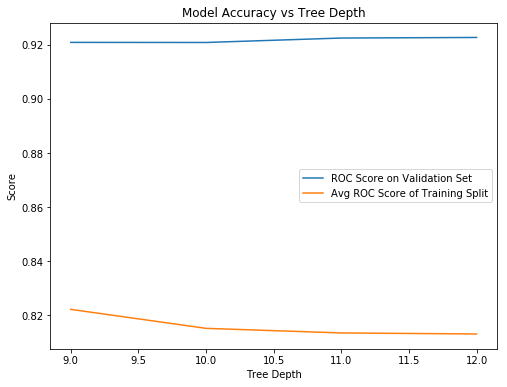

In [48]:
fig, ax = plt.subplots(figsize=(8,6))
_ = plt.plot(depths, val_auc, label='ROC Score on Validation Set')
_ = plt.plot(depths, aucs, label='Avg ROC Score of Training Split')
_ = plt.title('Model Accuracy vs Tree Depth')
_ = plt.xlabel('Tree Depth')
_ = plt.ylabel('Score')
_ = plt.legend()

### Tree Depths 9-12 are no better than Depth 8, so we will say Depth 8 is optimal.

In [199]:
#Train our xgb model with optimal depth
dtrain = xgb.DMatrix(X_train, y_train)
model = xgb.train({'max_depth':8, 'eta':0.05, 'gamma':1.5, 'silent':1, 
                 'objective':'binary:logistic', 'early_stopping_rounds':5, 
                 'scale_pos_weight':ratio}, dtrain, 800)

# 1.1) What is the Effect of Monthly Income to the Prediction?

In [200]:
#Find how likely our model is to classify a random sample as delinquent
dtest = xgb.DMatrix(X_test, y_test)
pred = model.predict(dtest)
base_pred = pred.mean()
pred.mean()

0.22397321

In [206]:
# Find how likely our model is to classify a random sample as delinquent as we bump everyone's monthly pay up
# 1000 dollars at a time
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

bonuses = [0, 1000, 2000, 3000, 4000, 5000]
avg = []
avg.append(base_pred)
for i in range(0,5):
    X_test['MonthlyIncome'] += 1000

    dtest = xgb.DMatrix(X_test, y_test)
    pred = model.predict(dtest)
    avg.append(pred.mean())
    

C:\Users\caleb\Anaconda3\envs\neuralnets\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


No handles with labels found to put in legend.


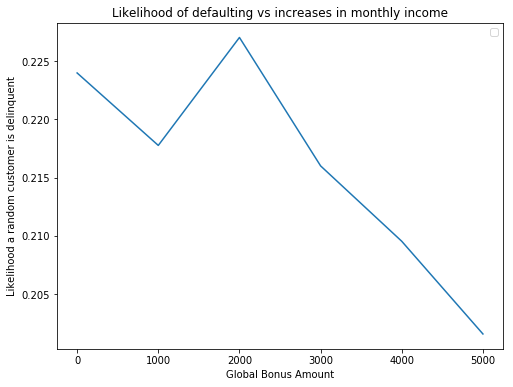

In [217]:
fig, ax = plt.subplots(figsize=(8,6))
_ = plt.plot(bonuses, avg)
_ = plt.title('Likelihood of defaulting vs increases in monthly income')
_ = plt.xlabel('Global Bonus Amount')
_ = plt.ylabel('Likelihood a random customer is delinquent')
_ = plt.legend()

### We see that as monthly income is increased for all customers by 1000 from no income, the chances of defaulting dropped slightly, but rose again when the average income was raised by 2000. When more than about 2200 is given to each customer per month, the chances of going delinquent again decrease.

### This suggests that there is some non-zero income level which implies a more financially unstable situation than having no income at all. 

# 1.2) Most Important Variable

In [208]:
#Use our xgb boost object to print a list of feature importances
model.get_fscore()


{'RevolvingUtilizationOfUnsecuredLines': 14149,
 'NumberOfTime30-59DaysPastDueNotWorse': 3019,
 'NumberOfTimes90DaysLate': 1923,
 'NumberOfTime60-89DaysPastDueNotWorse': 1735,
 'NumberRealEstateLoansOrLines': 2014,
 'age': 9542,
 'NumberOfOpenCreditLinesAndLoans': 6578,
 'DebtRatio': 15846,
 'MonthlyIncome': 10517,
 'NumberOfDependents': 2601}

### Our boost object tells us that DebtRatio and RevolvingUtilizationOfUnsecuredLines are the two most important features.

# 1.3) Age Discrimination

In [209]:
# Find how likely our model is to classify a random sample as delinquent as we bump everyone's age up
# 5 years at a time
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

agebumps = [0, 5, 10, 15, 20]
ageavg = []
ageavg.append(base_pred)
for i in range(0,4):
    X_test['age'] += 5

    dtest = xgb.DMatrix(X_test, y_test)
    pred = model.predict(dtest)
    ageavg.append(pred.mean())

C:\Users\caleb\Anaconda3\envs\neuralnets\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


No handles with labels found to put in legend.


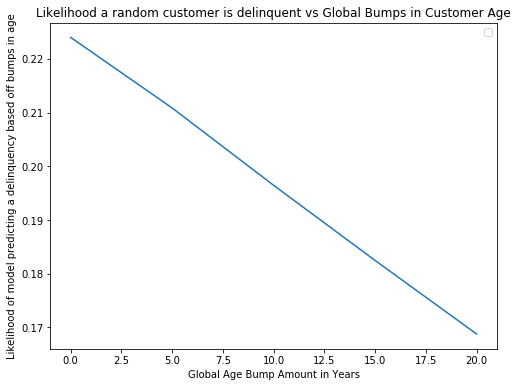

In [216]:
fig, ax = plt.subplots(figsize=(8,6))
_ = plt.plot(agebumps, ageavg)
_ = plt.title('Likelihood a random customer is delinquent vs Global Bumps in Customer Age')
_ = plt.xlabel('Global Age Bump Amount in Years')
_ = plt.ylabel('Likelihood of model predicting a delinquency based off bumps in age')
_ = plt.legend()

### We can see that our model actually favors customers that are older. We are less likely to predict a delinquency on average as our customers' average age increases. 

### An increase on average customer age of 20 years reduces the chances of a random customer being delinquent (according to our model) by over 5%. A significant drop.

In [211]:
# Find how likely our model is to classify a random sample as delinquent as we bump everyone's number of dependents up
# 1 dependent at a time
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

numkids = [0,1,2,3,4,5,6,7,8,9,10]
depavg = []
depavg.append(base_pred)
for i in range(0,10):
    X_test['NumberOfDependents'] += 1

    dtest = xgb.DMatrix(X_test, y_test)
    pred = model.predict(dtest)
    depavg.append(pred.mean())

C:\Users\caleb\Anaconda3\envs\neuralnets\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


No handles with labels found to put in legend.


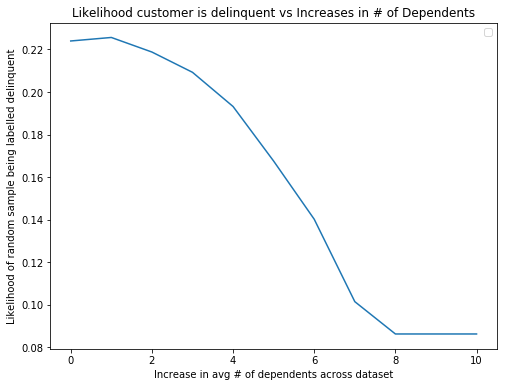

In [215]:
fig, ax = plt.subplots(figsize=(8,6))
_ = plt.plot(numkids, depavg)
_ = plt.title('Likelihood customer is delinquent vs Increases in # of Dependents')
_ = plt.xlabel('Increase in avg # of dependents across dataset')
_ = plt.ylabel('Likelihood of random sample being labelled delinquent')
_ = plt.legend()

### Interestingly, having several kids appears to significantly reduce the chance someone will be delinquent. I did not expect this, but it makes sense that people with children are more likely to be financially responsible.

### I am curious why the drop was so drastic when the XGB model said this feature was not important in determining a delinquency.

# 2) 

### In probability theory, two real-valued RV's X,Y are said to be uncorrelated if their covariance is zero. In mathetmatical terms: $$cov(X,Y)=E[XY]-E[X]E[Y]=0$$

### Let:  $$X=[-1,1]$$ $$Y=X^{2}$$

In [224]:
#Create 20,000 samples of each RV
xs = []
ys = []
x=-1
for i in range(0,20000):
    y = x*x
    ys.append(y)
    xs.append(x)
    x+= .0001
    

In [227]:
#Calculate E[Y]
total = 0
for item in ys:
    total += item
expy = total/20000
expy

0.3333333349999433

In [230]:
#Calculate E[XY]
total
for i in range(0,20000):
    total += xs[i]*ys[i]
expxy = total/20000
expxy

-0.0001500000002795934

### We see that: $$E[XY] = 0$$ $$E[X] = 0$$ So, these random variables are, by definition, uncorrelated, and they are clearly not independent, as one random variable tells you everything about the other.

In [236]:
newxs = []
newys = []
for i in range(0,1000):
    sample = random.randint(0,20001)
    newxs.append(xs[sample])
    newys.append(ys[sample])



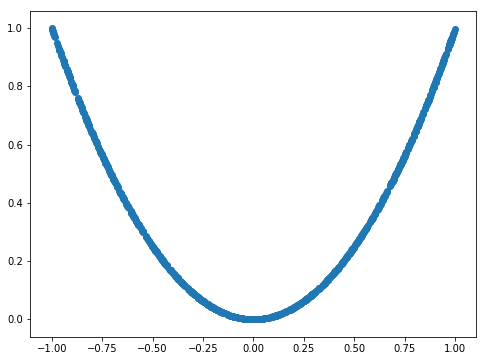

In [238]:
fig, ax = plt.subplots(figsize=(8,6))
_ = plt.scatter(newxs, newys)


In [2]:
xs = pd.DataFrame(xs)
ys = pd.DataFrame(ys)

X_train, X_test, y_train, y_test = train_test_split(xs, ys, test_size=0.33, random_state=42)

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
regr.coef_


NameError: name 'pd' is not defined

### We see that the optimal 1st order linear model will be a line with a slope of 0. The line will likely lie along the X-Axis, as that is the area where the most samples lie.

# 3)

### a. Install Tensorflow and Keras. Complete the tutorial.

#### Import the Fashion MNIST dataset

In [253]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
%matplotlib inline

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.10.0


In [254]:
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 1s 0us/step


In [255]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#### Explore the data

In [256]:
train_images.shape

(60000, 28, 28)

In [257]:
len(train_labels)

60000

In [258]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [259]:
test_images.shape

(10000, 28, 28)

In [260]:
len(test_labels)

10000

#### Preprocess the data

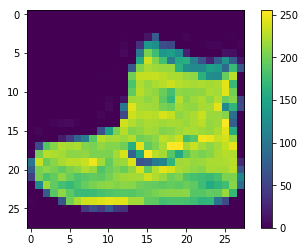

In [261]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)

In [262]:
train_images = train_images / 255.0
test_images = test_images / 255.0

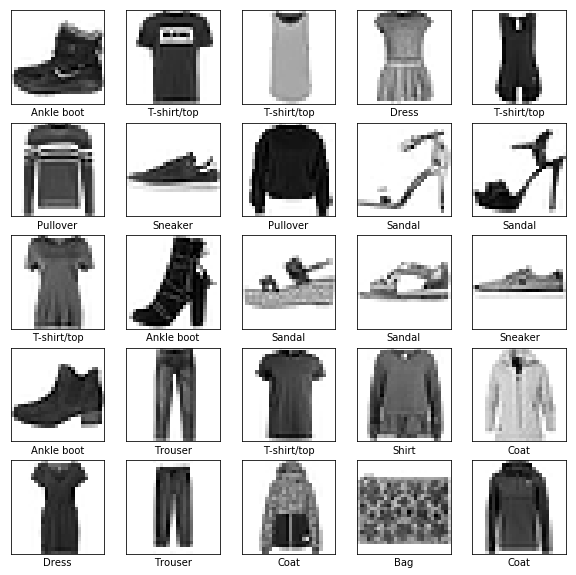

In [263]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

#### Build the model

In [264]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

#### Compile the model

In [265]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### Train the model

In [266]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 7s 121us/step - loss: 0.5016 - acc: 0.8242
Epoch 2/5
60000/60000 [==============================] - 5s 77us/step - loss: 0.3742 - acc: 0.8667
Epoch 3/5
60000/60000 [==============================] - 5s 79us/step - loss: 0.3363 - acc: 0.8781
Epoch 4/5
60000/60000 [==============================] - 5s 81us/step - loss: 0.3114 - acc: 0.8851
Epoch 5/5
60000/60000 [==============================] - 5s 77us/step - loss: 0.2945 - acc: 0.8911


#### Evaluate accuracy

In [267]:
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 0s 35us/step
Test accuracy: 0.8703


#### Make predictions

In [268]:
predictions = model.predict(test_images)

In [269]:
predictions[0]

array([1.4096266e-06, 7.3247833e-08, 4.9313876e-08, 5.0755588e-08,
       3.7151310e-07, 3.2826502e-02, 2.5826549e-07, 1.1248610e-02,
       4.5473786e-07, 9.5592219e-01], dtype=float32)

In [270]:
np.argmax(predictions[0])

9

In [271]:
test_labels[0]

9

In [272]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
 
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

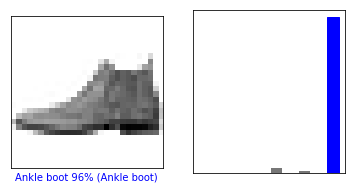

In [273]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

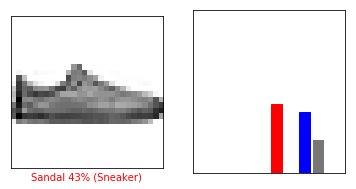

In [274]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

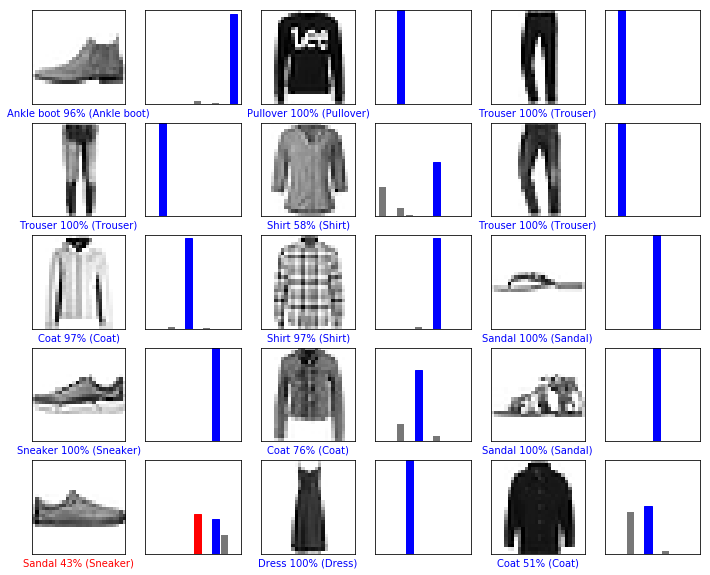

In [275]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)

In [276]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28)


In [277]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))

print(img.shape)

(1, 28, 28)


In [278]:
predictions_single = model.predict(img)

print(predictions_single)

[[1.4096266e-06 7.3247833e-08 4.9313968e-08 5.0755588e-08 3.7151381e-07
  3.2826513e-02 2.5826500e-07 1.1248605e-02 4.5473786e-07 9.5592219e-01]]


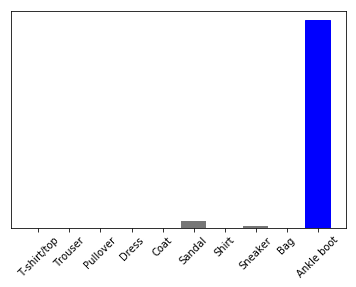

In [279]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [280]:
np.argmax(predictions_single[0])

9

# 3.b) 
### Create 5 new images by modifying current ones (e.g. by rotation, translation or stretching). Try your best model on them. How accurate is it? Should you be modifying images from the training set or test set?

#### We should be modifying images from the test set. We want to test how our already trained model responds to modified data. To do this, we tried a few different modifications to the entire test set in batch and calculated the loss. We found that none of the modifications (outside of doubling pixel values) were handled well by the classifier.

#### Explore shape of data

In [281]:
test_images.shape

(10000, 28, 28)

In [282]:
test_images[0].shape

(28, 28)

In [283]:
def heatmap(img):
    plt.figure()
    plt.imshow(img)
    plt.colorbar()
    plt.grid(False)

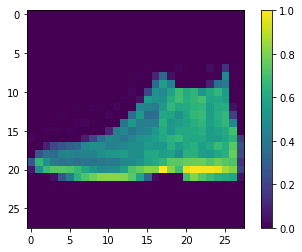

In [284]:
heatmap(test_images[0])

#### Rotation

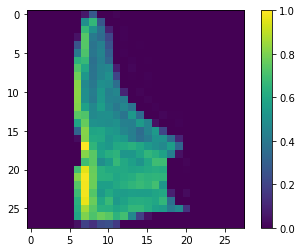

In [285]:
rotated_image0 = list(zip(*test_images[0][::-1]))
heatmap(rotated_image0)

In [286]:
rotated_images = []
for image in test_images:
    newimage = list(zip(*image[::-1]))
    rotated_images.append(newimage)
rotated_images = np.asarray(rotated_images)    
#rotated_images = np.rot90(np.asarray(test_images))

In [287]:
rotated_images.shape

(10000, 28, 28)

In [288]:
test_loss, test_acc = model.evaluate(rotated_images, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 0s 35us/step
Test accuracy: 0.0528


#### Rotation 2

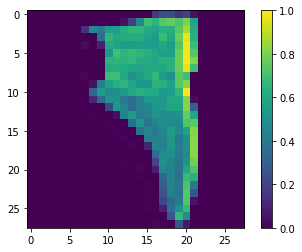

In [289]:
rotated_image0 = list(zip(*test_images[0][::-1]))
rotated_image0 = list(zip(*rotated_image0[::-1]))
rotated_image0 = list(zip(*rotated_image0[::-1]))
heatmap(rotated_image0)

In [290]:
rotated_images = []
for image in test_images:
    newimage = list(zip(*image[::-1]))
    newimage = list(zip(*newimage[::-1]))
    newimage = list(zip(*newimage[::-1]))
    rotated_images.append(newimage)
rotated_images = np.asarray(rotated_images)    
#rotated_images = np.rot90(np.asarray(test_images))

In [291]:
rotated_images.shape

(10000, 28, 28)

In [292]:
test_loss, test_acc = model.evaluate(rotated_images, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 0s 27us/step
Test accuracy: 0.0201


#### Reflection about origin

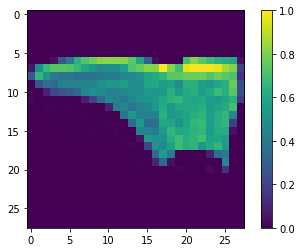

In [293]:
reflected_image0 = np.flip(test_images[0],0)
heatmap(reflected_image0)

In [294]:
reflected_images = np.flip(test_images,0)

In [295]:
reflected_images.shape

(10000, 28, 28)

In [296]:
test_loss, test_acc = model.evaluate(reflected_images, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 0s 28us/step
Test accuracy: 0.1024


#### Double the values

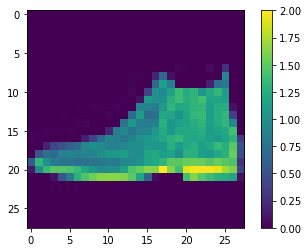

In [297]:
a = np.array(test_images[0])
shaded1_image0 = np.kron(a, [[2]])
heatmap(shaded1_image0)

In [298]:
a = np.array(test_images)
doubled_images = np.kron(a, [[2]])

In [299]:
doubled_images.shape

(10000, 28, 28)

In [300]:
test_loss, test_acc = model.evaluate(doubled_images, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 0s 27us/step
Test accuracy: 0.8684


#### Blurring

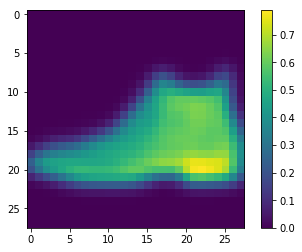

In [302]:
from scipy.ndimage.filters import gaussian_filter
blurred_image0 = blurred = gaussian_filter(test_images[0], sigma=1)
heatmap(blurred_image0)

In [303]:
blurred_images = blurred = gaussian_filter(test_images, sigma=1)

In [304]:
test_loss, test_acc = model.evaluate(blurred_images, test_labels)

print('Test accuracy:', test_acc)

10000/10000 [==============================] - 0s 27us/step
Test accuracy: 0.3822


#### Results:

#### Outside of doubling the value of each pixel, the classifier did not perform well on any of the transformed images. The model is not accurate

### c. Download the pre-trained Inception-v3 model and run it on some images of your own choice.

In [305]:
![title](inception.png)

'[title]' is not recognized as an internal or external command,
operable program or batch file.


#  4)

### Form the final project teams and make your project proposal.

Our team is:

Aimun Khan (me)

Caleb Johnson

Nimay Kumar

Michael Arthur

Reid Wyde

### What datasets are you planning to use/collect?

We found a dataset of play-by-play data from every NBA game since 1950. This dataset includes information about every shot taken by a player, whether the shot is a make or miss, where other players on the court are relative to the shooting player, and what the time and score are during the shot.

We also have a dataset of aggregate stats and information about every NBA player from every season since 1950. https://www.kaggle.com/drgilermo/nba-players-stats#Seasons_Stats.csv

### What are you planning to do with them?

Using this data, we want to build a model that can predict the accuracy of a player's shooting given a hot streak  (multiple made shots in the past) as well as featurse of the court, score, and time. In basketball, there is a theory that some people have that players will get a "hot hand" when making multiple shots in a row, meaning that the momentum of scoring increases their accuracy. We want to test this theory using the data. We also want to examine how other features such as defenders, score, and time on the clock affect how players shoot.